# intro to ML project
## using DCGAN to generate 2D anime faces
In this project, we trying to build a DCGAN model to train on the anime faces and generate some.

We run this on the GCP, using GPU to train the model.

First, import some library might be use in this project.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow.contrib.layers as ly
import time
from skimage import io 
import random
from scipy.misc import imread, imresize
import pickle 
import os
import cv2
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5813166657608910412, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16935415040937119093
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9855733418522991599
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15856546612
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9440813027530854719
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

## Load the data
We using the data set for https://drive.google.com/drive/folders/1mCsY5LEsgCnc0Txv0rpAUhKVPWVkbw5I?usp=sharing.

Inside the google drive, there is a faces.tar.
After unzip it, there will be 33423 pictures of anime faces.

We normalize the pictures in channel.

In [2]:
file_path = 'faces'
def load_data(file_path):
    temp = os.listdir(file_path)
    image_list = []
    for i in temp : 
        kk = os.path.join(file_path,i)
        te = imread(kk)
        te = (te /127.5)-1
        te = cv2.resize(te, (64, 64), interpolation=cv2.INTER_CUBIC)
        image_list.append(te)
    return image_list

In [3]:
image_list  = load_data(file_path)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


In [4]:
def lrelu(x, leak=0.3, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [5]:
def plot(x):
    x = x - np.min(x)
    x /= np.max(x)
    x *= 255 
    x= x.astype(np.uint8)
    x = x.reshape(64,64,3)
    return x

In [6]:
batch_size = 64

tf.reset_default_graph()

real_image = tf.placeholder(tf.float32,shape=(None,64,64,3))

noise = tf.placeholder(tf.float32,shape=(None,100))

channel = 3 

## Build a network
Define the generator and discriminator.

|Generator Model|
-|
|fully_connected(4*4*512) + batch_normalization|
|Conv2d_tranpose(256, (5,5), stride=2+ batch_normalization|
|Conv2d_tranpose(128, (5,5), stride=2+ batch_normalization|
|Conv2d_tranpose(64, (5,5), stride=2+ batch_normalization|
|Conv2d_tranpose(32, (5,5), stride=2+ batch_normalization|
|Conv2d_tranpose(3, (5,5), stride=2)|

In [7]:
def generator_conv(z):
    train = ly.fully_connected(
        z, 4* 4 *512 , activation_fn=tf.nn.leaky_relu, normalizer_fn=ly.batch_norm)
    train = tf.reshape(train, (-1, 4, 4,512))
    train = ly.conv2d_transpose(train, 256, 5, stride=2,normalizer_fn=ly.batch_norm,
                                activation_fn=tf.nn.leaky_relu, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    train = ly.conv2d_transpose(train, 128, 5, stride=2,normalizer_fn=ly.batch_norm,
                                activation_fn=tf.nn.leaky_relu, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    train = ly.conv2d_transpose(train, 64, 5, stride=2,normalizer_fn=ly.batch_norm,
                                activation_fn=tf.nn.leaky_relu, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    train = ly.conv2d_transpose(train, 32 , 5, stride=2,normalizer_fn=ly.batch_norm,
                                activation_fn=tf.nn.leaky_relu, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    train = ly.conv2d_transpose(train, channel, 5, stride=1,
                                activation_fn=tf.nn.tanh, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
    return train

|Discriminator Model|
-|
|Conv2d_tranpose(64, (5,5), stride=2+ leakly_relu|
|Conv2d_tranpose(128, (5,5), stride=2+ leakly_relu|
|Conv2d_tranpose(256, (5,5), stride=2+ leakly_relu|
|Conv2d_tranpose(512, (5,5), stride=2+ leakly_relu|
|fully_connected|

In [8]:
def dis_conv(img, reuse=False):
    with tf.variable_scope('dis_conv') as scope:
        if reuse:
            scope.reuse_variables()
        size = 64
        img = ly.conv2d(img, num_outputs=size, kernel_size=5,padding='SAME', normalizer_fn=ly.batch_norm,
                        stride=2, activation_fn=tf.nn.leaky_relu)
        img = ly.conv2d(img, num_outputs=size * 2, kernel_size=5,padding='SAME',
                        stride=2, activation_fn=tf.nn.leaky_relu, normalizer_fn=ly.batch_norm)
        img = ly.conv2d(img, num_outputs=size * 4, kernel_size=5,padding='SAME',
                        stride=2, activation_fn=tf.nn.leaky_relu, normalizer_fn=ly.batch_norm)
        img = ly.conv2d(img, num_outputs=size * 8, kernel_size=5,padding='SAME',
                        stride=2, activation_fn=tf.nn.leaky_relu, normalizer_fn=ly.batch_norm)
        source_logit = ly.fully_connected(tf.reshape(
            img, [batch_size, 4*4*512]), 1, activation_fn=None)

    return source_logit

In [9]:
with tf.variable_scope('generator_conv'):
    sythetic_image = generator_conv(noise)

Instructions for updating:
Colocations handled automatically by placer.


Using the logits for generated data and real data we define the loss functions for the Generator and Discriminator networks.

These losses are `sigmoid cross entropy`.

In [10]:
tf.summary.image('sythetic_image',sythetic_image)

logits_fake = dis_conv(sythetic_image,reuse=False)

logits_real = dis_conv(real_image,reuse=True)

In [11]:
fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_fake),logits=logits_fake))

real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_real),logits=logits_real))

d_loss = fake_loss + real_loss

tf.summary.scalar('d_loss',d_loss)

g_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(tf.ones_like(logits_fake),logits=logits_fake))

tf.summary.scalar('g_loss',g_loss)

Instructions for updating:
Use tf.cast instead.


<tf.Tensor 'g_loss:0' shape=() dtype=string>

We define the optimizers for the two networks using the loss functions defined above and scope of the layers defined in the generator and discriminator functions.

We use Adam Optimizer for both the networks with the learning rate as `0.0001`. 

In [12]:
theta_g = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator_conv')
    
theta_c = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope='dis_conv')

In [13]:
counter_g = tf.Variable(trainable=False, initial_value=0, dtype=tf.int32)

g_opt = tf.train.AdamOptimizer(0.0001).minimize(g_loss,var_list=theta_g)

counter_c = tf.Variable(trainable=False, initial_value=0, dtype=tf.int32)

d_opt = tf.train.AdamOptimizer(0.0001).minimize(d_loss,var_list=theta_c)

In [14]:
sess = tf.Session()

init = tf.global_variables_initializer()

sess.run(init)

saver = tf.train.Saver()

merged = tf.summary.merge_all()

We set a function to run through different batches.

In [15]:
def next_batch(input_image , batch_size=64):
    le = len(input_image)
    epo = le//batch_size
    np.random.shuffle(input_image)
    for i in range(0,epo*batch_size,64):
        yield np.array(input_image[i:i+64])

We set a function to show the pictures that generator create.

In [16]:
def show(no):
    rs= sess.run(sythetic_image,feed_dict={noise:no})
    overall = []
    for i in range(8):
        temp = []
        for j in range(8):
            temp.append(plot(rs[i * 8 + j]))
        overall.append(np.concatenate(temp, axis=1))
    res = np.concatenate(overall, axis=0)
    res = np.squeeze(res)
    #res = (res+1)/2
    plt.figure(figsize=[8, 8])
    plt.imshow(res)
    plt.show()

## Train the nerwork
Train the network for `300` epoch.

From https://github.com/carpedm20/DCGAN-tensorflow.
To avoid the fast convergence of D (discriminator) network, G (generator) network is updated twice for each D network update, which differs from original paper.

Show the picture every `25` epoch.

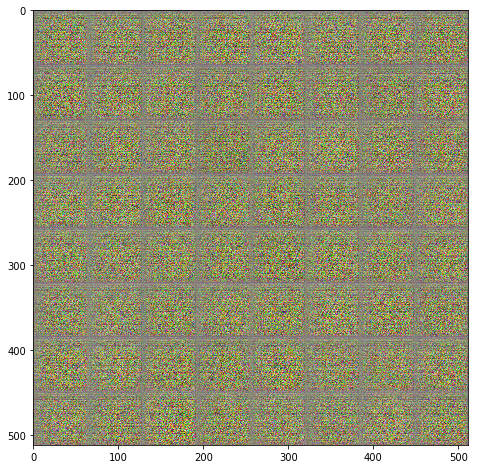

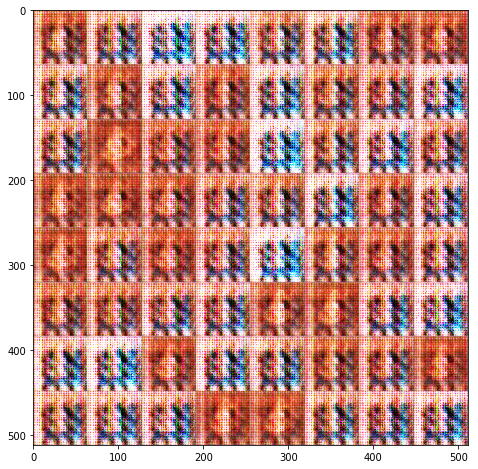

1/300 epochs , cost 68.43093228340149 sec
2/300 epochs , cost 67.55387473106384 sec
3/300 epochs , cost 67.44569873809814 sec
4/300 epochs , cost 67.46322751045227 sec
5/300 epochs , cost 67.40755081176758 sec
6/300 epochs , cost 67.51538872718811 sec
7/300 epochs , cost 67.51334023475647 sec
8/300 epochs , cost 67.5103714466095 sec
9/300 epochs , cost 67.47314095497131 sec
10/300 epochs , cost 67.50631213188171 sec
11/300 epochs , cost 67.40025591850281 sec
12/300 epochs , cost 67.36736464500427 sec
13/300 epochs , cost 67.29449319839478 sec
14/300 epochs , cost 67.14588236808777 sec
15/300 epochs , cost 67.12344622612 sec
16/300 epochs , cost 67.0960419178009 sec
17/300 epochs , cost 67.30729389190674 sec
18/300 epochs , cost 67.2258813381195 sec
19/300 epochs , cost 67.21312308311462 sec
20/300 epochs , cost 67.29183793067932 sec
21/300 epochs , cost 67.3181140422821 sec
22/300 epochs , cost 67.24272894859314 sec
23/300 epochs , cost 67.27367973327637 sec
24/300 epochs , cost 67.358

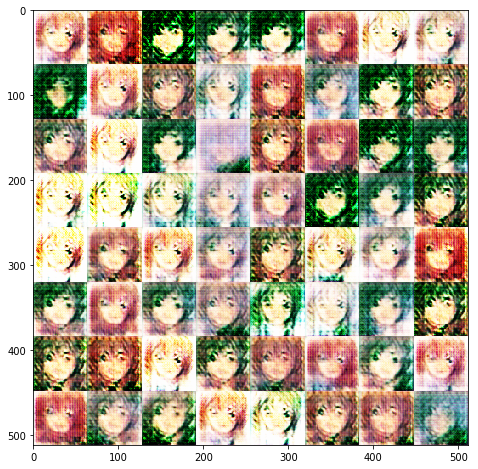

26/300 epochs , cost 67.4502604007721 sec
27/300 epochs , cost 67.22944831848145 sec
28/300 epochs , cost 67.29807353019714 sec
29/300 epochs , cost 67.34120631217957 sec
30/300 epochs , cost 67.3288266658783 sec
31/300 epochs , cost 67.31444573402405 sec
32/300 epochs , cost 67.35088634490967 sec
33/300 epochs , cost 67.40413427352905 sec
34/300 epochs , cost 67.30473947525024 sec
35/300 epochs , cost 67.31525254249573 sec
36/300 epochs , cost 67.30700945854187 sec
37/300 epochs , cost 67.24304604530334 sec
38/300 epochs , cost 67.44345426559448 sec
39/300 epochs , cost 67.46553087234497 sec
40/300 epochs , cost 67.41389417648315 sec
41/300 epochs , cost 67.35064005851746 sec
42/300 epochs , cost 67.44120597839355 sec
43/300 epochs , cost 67.48110222816467 sec
44/300 epochs , cost 67.4943175315857 sec
45/300 epochs , cost 67.45412087440491 sec
46/300 epochs , cost 67.41567707061768 sec
47/300 epochs , cost 67.46699261665344 sec
48/300 epochs , cost 67.17840504646301 sec
49/300 epochs 

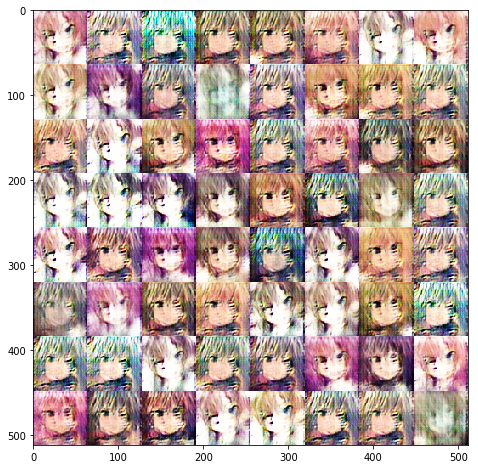

51/300 epochs , cost 67.49344110488892 sec
52/300 epochs , cost 68.01872825622559 sec
53/300 epochs , cost 68.05659937858582 sec
54/300 epochs , cost 68.06519150733948 sec
55/300 epochs , cost 67.75236463546753 sec
56/300 epochs , cost 67.92535281181335 sec
57/300 epochs , cost 67.92049288749695 sec
58/300 epochs , cost 67.93034315109253 sec
59/300 epochs , cost 68.03850054740906 sec
60/300 epochs , cost 68.06252431869507 sec
61/300 epochs , cost 67.99161148071289 sec
62/300 epochs , cost 68.05028939247131 sec
63/300 epochs , cost 67.98079562187195 sec
64/300 epochs , cost 67.81229138374329 sec
65/300 epochs , cost 68.23289966583252 sec
66/300 epochs , cost 67.8023829460144 sec
67/300 epochs , cost 67.80270171165466 sec
68/300 epochs , cost 67.76974153518677 sec
69/300 epochs , cost 67.70256733894348 sec
70/300 epochs , cost 67.72554993629456 sec
71/300 epochs , cost 67.71129751205444 sec
72/300 epochs , cost 67.60633087158203 sec
73/300 epochs , cost 67.77063345909119 sec
74/300 epoch

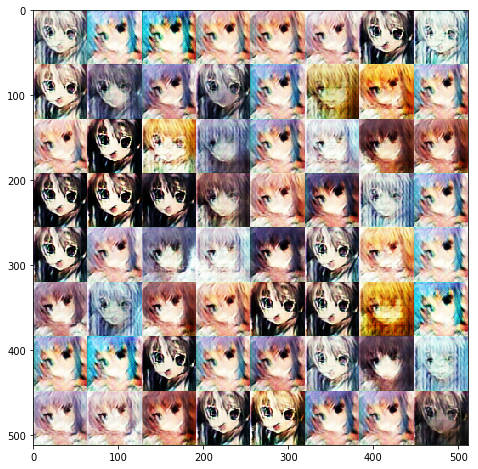

76/300 epochs , cost 67.77287650108337 sec
77/300 epochs , cost 67.75492572784424 sec
78/300 epochs , cost 67.60944032669067 sec
79/300 epochs , cost 67.78131079673767 sec
80/300 epochs , cost 67.51189494132996 sec
81/300 epochs , cost 67.80924844741821 sec
82/300 epochs , cost 67.72613596916199 sec
83/300 epochs , cost 67.60117721557617 sec
84/300 epochs , cost 67.81015253067017 sec
85/300 epochs , cost 67.72252440452576 sec
86/300 epochs , cost 67.68784356117249 sec
87/300 epochs , cost 67.63530564308167 sec
88/300 epochs , cost 67.68624019622803 sec
89/300 epochs , cost 67.6192901134491 sec
90/300 epochs , cost 67.68652415275574 sec
91/300 epochs , cost 67.66508102416992 sec
92/300 epochs , cost 67.6940553188324 sec
93/300 epochs , cost 67.74964714050293 sec
94/300 epochs , cost 67.69377303123474 sec
95/300 epochs , cost 67.73932218551636 sec
96/300 epochs , cost 67.88924360275269 sec
97/300 epochs , cost 67.96258211135864 sec
98/300 epochs , cost 67.8378586769104 sec
99/300 epochs 

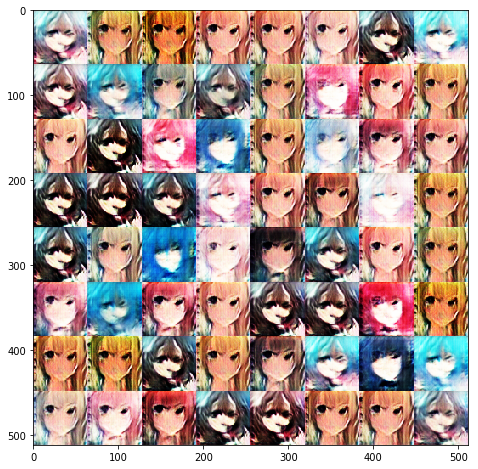

101/300 epochs , cost 67.83587074279785 sec
102/300 epochs , cost 67.46230983734131 sec
103/300 epochs , cost 67.46677231788635 sec
104/300 epochs , cost 67.36996626853943 sec
105/300 epochs , cost 67.44785261154175 sec
106/300 epochs , cost 67.47478723526001 sec
107/300 epochs , cost 67.60901021957397 sec
108/300 epochs , cost 67.52028012275696 sec
109/300 epochs , cost 67.36427402496338 sec
110/300 epochs , cost 67.41040468215942 sec
111/300 epochs , cost 67.65833139419556 sec
112/300 epochs , cost 67.38729166984558 sec
113/300 epochs , cost 67.41549587249756 sec
114/300 epochs , cost 67.2919385433197 sec
115/300 epochs , cost 67.39189839363098 sec
116/300 epochs , cost 67.44415402412415 sec
117/300 epochs , cost 67.37774443626404 sec
118/300 epochs , cost 67.32325625419617 sec
119/300 epochs , cost 67.36223006248474 sec
120/300 epochs , cost 67.40288925170898 sec
121/300 epochs , cost 67.5883002281189 sec
122/300 epochs , cost 67.50409483909607 sec
123/300 epochs , cost 67.645943403

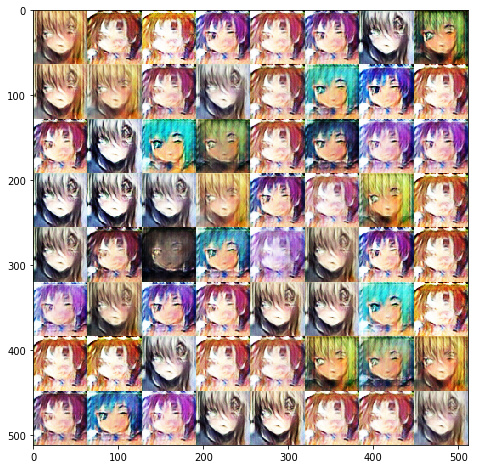

126/300 epochs , cost 67.44368386268616 sec
127/300 epochs , cost 67.30649018287659 sec
128/300 epochs , cost 67.52374315261841 sec
129/300 epochs , cost 67.343576669693 sec
130/300 epochs , cost 67.46969819068909 sec
131/300 epochs , cost 67.50270342826843 sec
132/300 epochs , cost 67.57786345481873 sec
133/300 epochs , cost 67.45969200134277 sec
134/300 epochs , cost 67.43726015090942 sec
135/300 epochs , cost 67.39642691612244 sec
136/300 epochs , cost 67.27074193954468 sec
137/300 epochs , cost 67.4557273387909 sec
138/300 epochs , cost 67.42937302589417 sec
139/300 epochs , cost 67.2297797203064 sec
140/300 epochs , cost 66.89811587333679 sec
141/300 epochs , cost 67.28734874725342 sec
142/300 epochs , cost 68.10411620140076 sec
143/300 epochs , cost 67.13443684577942 sec
144/300 epochs , cost 67.44415879249573 sec
145/300 epochs , cost 67.05764389038086 sec
146/300 epochs , cost 67.05331778526306 sec
147/300 epochs , cost 67.38665628433228 sec
148/300 epochs , cost 67.44280624389

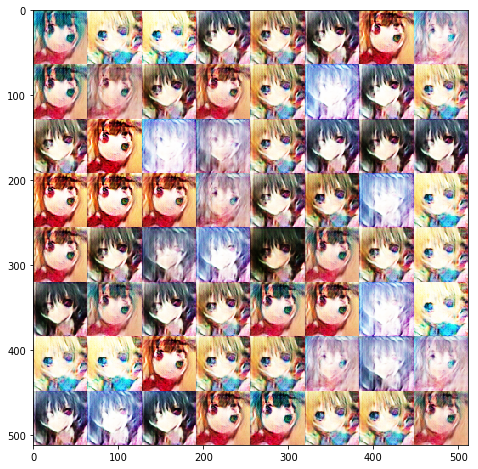

151/300 epochs , cost 67.26444220542908 sec
152/300 epochs , cost 67.58677697181702 sec
153/300 epochs , cost 67.70085501670837 sec
154/300 epochs , cost 67.51253724098206 sec
155/300 epochs , cost 67.66742515563965 sec
156/300 epochs , cost 67.76735734939575 sec
157/300 epochs , cost 67.70174407958984 sec
158/300 epochs , cost 67.71585965156555 sec
159/300 epochs , cost 67.63805365562439 sec
160/300 epochs , cost 67.7243390083313 sec
161/300 epochs , cost 67.73191618919373 sec
162/300 epochs , cost 67.64808678627014 sec
163/300 epochs , cost 67.68719816207886 sec
164/300 epochs , cost 67.72602772712708 sec
165/300 epochs , cost 67.76347136497498 sec
166/300 epochs , cost 67.69736170768738 sec
167/300 epochs , cost 67.75710129737854 sec
168/300 epochs , cost 67.55820560455322 sec
169/300 epochs , cost 67.41193079948425 sec
170/300 epochs , cost 67.7231171131134 sec
171/300 epochs , cost 67.76424074172974 sec
172/300 epochs , cost 67.75294613838196 sec
173/300 epochs , cost 67.676347494

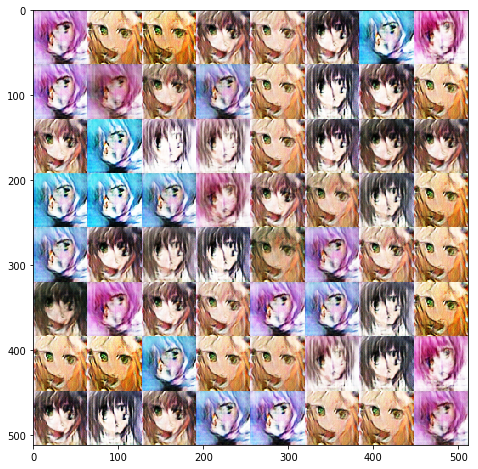

176/300 epochs , cost 67.87660050392151 sec
177/300 epochs , cost 67.77558827400208 sec
178/300 epochs , cost 67.80760025978088 sec
179/300 epochs , cost 67.77341270446777 sec
180/300 epochs , cost 67.9737536907196 sec
181/300 epochs , cost 67.92600965499878 sec
182/300 epochs , cost 67.8568766117096 sec
183/300 epochs , cost 67.92735457420349 sec
184/300 epochs , cost 67.90655040740967 sec
185/300 epochs , cost 67.99143671989441 sec
186/300 epochs , cost 67.76346611976624 sec
187/300 epochs , cost 67.76274228096008 sec
188/300 epochs , cost 67.69987726211548 sec
189/300 epochs , cost 67.86017179489136 sec
190/300 epochs , cost 67.62389588356018 sec
191/300 epochs , cost 67.85421252250671 sec
192/300 epochs , cost 67.78704261779785 sec
193/300 epochs , cost 67.80667924880981 sec
194/300 epochs , cost 67.78133034706116 sec
195/300 epochs , cost 67.82890844345093 sec
196/300 epochs , cost 67.84511017799377 sec
197/300 epochs , cost 67.77794909477234 sec
198/300 epochs , cost 67.937458992

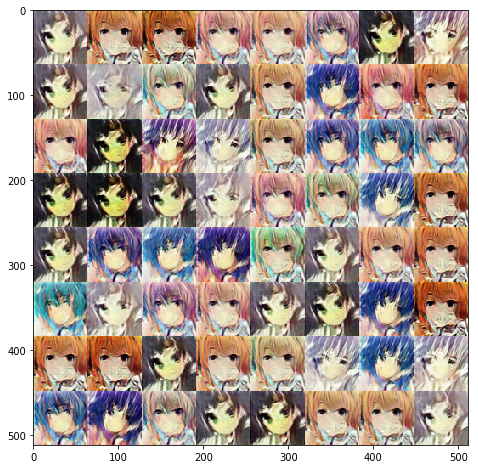

201/300 epochs , cost 67.8104178905487 sec
202/300 epochs , cost 67.94354343414307 sec
203/300 epochs , cost 67.9329297542572 sec
204/300 epochs , cost 67.83418416976929 sec
205/300 epochs , cost 67.72300004959106 sec
206/300 epochs , cost 67.65757441520691 sec
207/300 epochs , cost 67.85802459716797 sec
208/300 epochs , cost 67.66159915924072 sec
209/300 epochs , cost 67.81953763961792 sec
210/300 epochs , cost 67.71367311477661 sec
211/300 epochs , cost 67.95926356315613 sec
212/300 epochs , cost 67.84390330314636 sec
213/300 epochs , cost 67.80008697509766 sec
214/300 epochs , cost 67.83240175247192 sec
215/300 epochs , cost 67.82105135917664 sec
216/300 epochs , cost 67.96720886230469 sec
217/300 epochs , cost 67.76355981826782 sec
218/300 epochs , cost 67.84833240509033 sec
219/300 epochs , cost 67.82740783691406 sec
220/300 epochs , cost 68.03025889396667 sec
221/300 epochs , cost 68.16499590873718 sec
222/300 epochs , cost 67.70203256607056 sec
223/300 epochs , cost 68.133751869

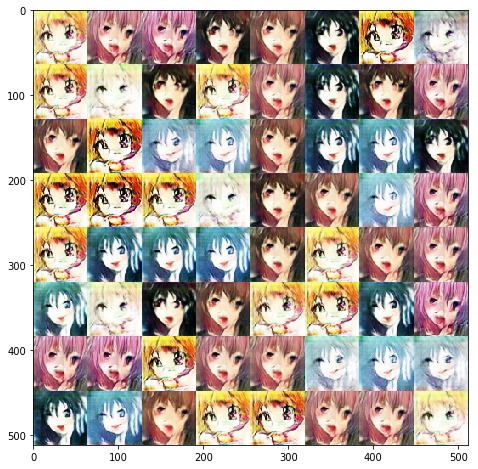

226/300 epochs , cost 67.95371532440186 sec
227/300 epochs , cost 67.5122435092926 sec
228/300 epochs , cost 67.56435132026672 sec
229/300 epochs , cost 67.40480375289917 sec
230/300 epochs , cost 67.27382469177246 sec
231/300 epochs , cost 67.5254578590393 sec
232/300 epochs , cost 67.53188133239746 sec
233/300 epochs , cost 67.52539038658142 sec
234/300 epochs , cost 67.57767748832703 sec
235/300 epochs , cost 67.57948088645935 sec
236/300 epochs , cost 67.56671166419983 sec
237/300 epochs , cost 67.35514998435974 sec
238/300 epochs , cost 67.28092908859253 sec
239/300 epochs , cost 67.55139827728271 sec
240/300 epochs , cost 67.46022534370422 sec
241/300 epochs , cost 67.41949915885925 sec
242/300 epochs , cost 67.51562833786011 sec
243/300 epochs , cost 67.56412291526794 sec
244/300 epochs , cost 67.77522158622742 sec
245/300 epochs , cost 67.51906490325928 sec
246/300 epochs , cost 67.55622839927673 sec
247/300 epochs , cost 67.64250636100769 sec
248/300 epochs , cost 67.478067398

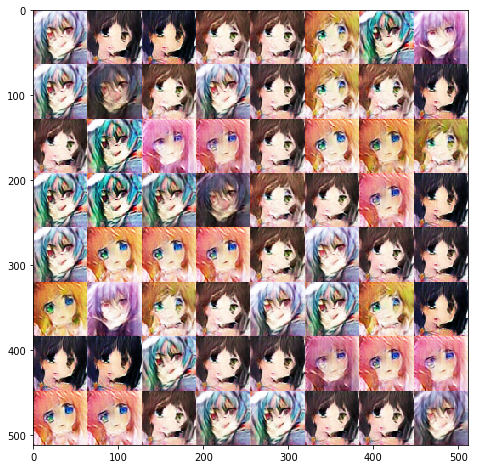

251/300 epochs , cost 67.50363111495972 sec
252/300 epochs , cost 67.47800159454346 sec
253/300 epochs , cost 67.66495561599731 sec
254/300 epochs , cost 67.63735580444336 sec
255/300 epochs , cost 67.58660292625427 sec
256/300 epochs , cost 67.5749876499176 sec
257/300 epochs , cost 67.67435503005981 sec
258/300 epochs , cost 67.64196801185608 sec
259/300 epochs , cost 67.48386120796204 sec
260/300 epochs , cost 67.6890811920166 sec
261/300 epochs , cost 67.56838726997375 sec
262/300 epochs , cost 67.66285395622253 sec
263/300 epochs , cost 67.82931709289551 sec
264/300 epochs , cost 67.80588102340698 sec
265/300 epochs , cost 67.59623432159424 sec
266/300 epochs , cost 67.5858542919159 sec
267/300 epochs , cost 67.86819076538086 sec
268/300 epochs , cost 67.55445623397827 sec
269/300 epochs , cost 67.7051465511322 sec
270/300 epochs , cost 67.8332257270813 sec
271/300 epochs , cost 67.65768957138062 sec
272/300 epochs , cost 67.77839589118958 sec
273/300 epochs , cost 67.565056324005

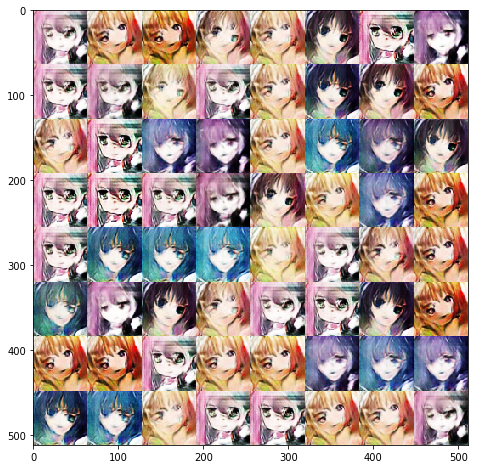

276/300 epochs , cost 67.48213338851929 sec
277/300 epochs , cost 67.40642213821411 sec
278/300 epochs , cost 67.57314085960388 sec
279/300 epochs , cost 67.32860350608826 sec
280/300 epochs , cost 67.31203269958496 sec
281/300 epochs , cost 67.550466299057 sec
282/300 epochs , cost 67.43517923355103 sec
283/300 epochs , cost 67.31192302703857 sec
284/300 epochs , cost 67.52870893478394 sec
285/300 epochs , cost 67.45755243301392 sec
286/300 epochs , cost 67.51663613319397 sec
287/300 epochs , cost 67.50775790214539 sec
288/300 epochs , cost 67.43610882759094 sec
289/300 epochs , cost 67.53583073616028 sec
290/300 epochs , cost 67.52148413658142 sec
291/300 epochs , cost 67.51784491539001 sec
292/300 epochs , cost 67.33279395103455 sec
293/300 epochs , cost 67.40788984298706 sec
294/300 epochs , cost 67.424072265625 sec
295/300 epochs , cost 67.53950238227844 sec
296/300 epochs , cost 67.5311324596405 sec
297/300 epochs , cost 67.33135533332825 sec
298/300 epochs , cost 67.468649387359

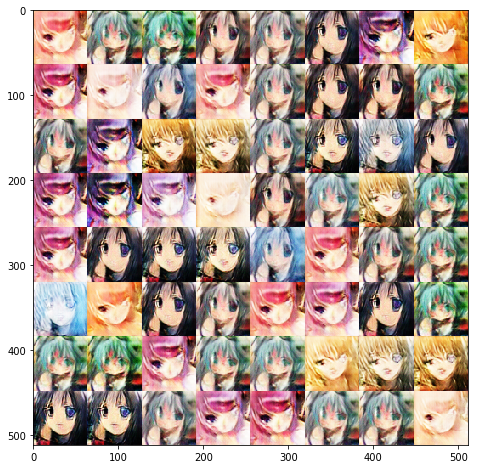

In [17]:
no = np.random.normal(size=(64,100))
show(no)

for i in range(300):
    #epoch_loss = []
    count = 0
    start  = time.time()
    for j in next_batch(image_list):
        batch_z = np.random.normal(size=[batch_size,100])
        feed_dict = {noise:batch_z, real_image:j}
        _,loss = sess.run([d_opt,d_loss], feed_dict=feed_dict)
        #epoch_loss.append(loss)
        
        for _ in range(2): 
            merge,_,loss = sess.run([merged,g_opt,g_loss],feed_dict={noise:batch_z,real_image:j})
    #merge = sess.run(merged, feed_dict={noise:batch_z, real_image:j})
    #writer.add_summary(merge,i)
    
    end = time.time()
    
    if (i % 25 == 0):
        show(no)
    print('{}/300 epochs , cost {} sec'.format(i+1,end-start))
    
show(no)

## Result
![Gif](https://github.com/jyRoyWang/introMLproject/blob/master/Result/DCGAN_result/DCGAN_gif.gif?raw=true)

## Save the pictures create from the network
After training the network, we create `5*5` pictures and save into one figure.

In [18]:
r, c = 5, 5
# gen_imgs should be shape (25, 64, 64, 3)
gen_imgs = sess.run(sythetic_image,feed_dict={noise:no})
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(plot(gen_imgs[cnt, :,:,:]))
        axs[i,j].axis('off')
        cnt += 1
fig.savefig("DCGAN_result.png")
plt.close()